# Parker Solar Probe Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from psp.config.psp import PSPConfig
from psp.plot import plot_event, plot_candidate_tplot
import pytplot
from discontinuitypy.utils.dataset import unique_events, keep_good_fit
from datetime import timedelta
import polars as pl

In [4]:
p_conf = PSPConfig(enc=7)

0 : psp_fld_l2_mag_RTN_4_Sa_per_Cyc
1 : psp_swp_spi_sf00_L3_DENS
2 : psp_swp_spi_sf00_L3_VEL_RTN_SUN
3 : psp_swp_spi_sf00_L3_VEL_RTN
4 : psp_swp_spi_af00_L3_DENS
5 : psp_swp_spi_af00_L3_VEL_RTN_SUN
6 : psp_swp_spi_af00_L3_VEL_RTN
7 : Tp_spani_b
8 : Tp_spanib_b


In [5]:
data, file = p_conf.produce_or_load()

## Discontinuities with B=const

In [6]:
import hvplot.xarray  # noqa

hvplot.extension("matplotlib")

24-Aug-24 12:49:58: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



2024-08-24 12:52:24.698 | INFO     | space_analysis.ds.tplot.formulary:ts_Alfven_speed:22 - Time of B and density are not the same, interpolating density to B


:Layout
   .Overlay.B           :Overlay
      .NdOverlay.B :NdOverlay   [v_dim]
         :Curve   [time]   ($B$)
   .Overlay.V           :Overlay
      .NdOverlay.V :NdOverlay   [v_dim]
         :Curve   [time]   ($V$)
   .Overlay.I           :Overlay
      .Curve.V_left_curly_bracket_A_comma_l_right_curly_bracket  :Curve   [time]   ($V_{A,l}$)
      .Curve.DV_left_curly_bracket_i_comma_l_right_curly_bracket :Curve   [time]   ($dV_{i,l}$)
   .Overlay.Ion_density :Overlay
      .Curve.Ion_density :Curve   [time]   (Ion density)
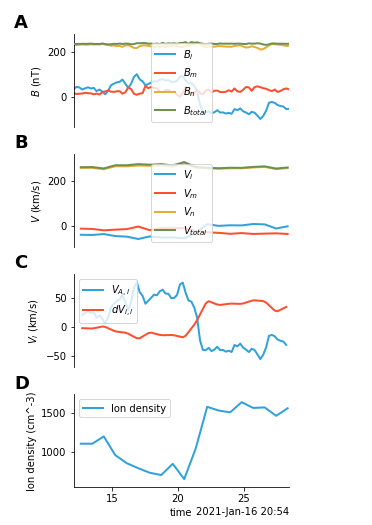

2024-08-24 12:52:25.270 | INFO     | space_analysis.ds.tplot.formulary:ts_Alfven_speed:22 - Time of B and density are not the same, interpolating density to B


:Layout
   .Overlay.B           :Overlay
      .NdOverlay.B :NdOverlay   [v_dim]
         :Curve   [time]   ($B$)
   .Overlay.V           :Overlay
      .NdOverlay.V :NdOverlay   [v_dim]
         :Curve   [time]   ($V$)
   .Overlay.I           :Overlay
      .Curve.V_left_curly_bracket_A_comma_l_right_curly_bracket  :Curve   [time]   ($V_{A,l}$)
      .Curve.DV_left_curly_bracket_i_comma_l_right_curly_bracket :Curve   [time]   ($dV_{i,l}$)
   .Overlay.Ion_density :Overlay
      .Curve.Ion_density :Curve   [time]   (Ion density)
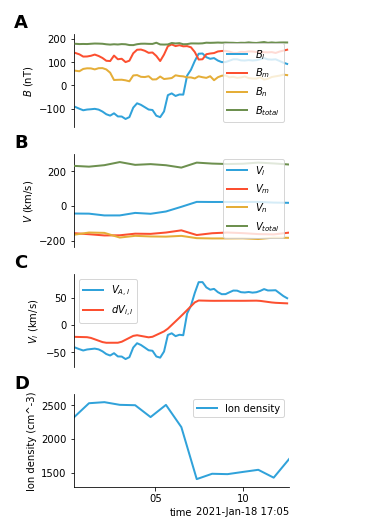

In [18]:
n = 2
events = (
    data.pipe(keep_good_fit)
    .pipe(unique_events)
    .filter(pl.col("db_over_b_max") < 0.05)
)

for event in events.head(n=n).rows(named=True):
    display(plot_candidate_tplot(event, offset=timedelta(seconds=5)))

We can see it is necessary to interpolate the magnetic field data to plasma data's time resolution to properly calculate the Alfvenicity.

## Discontinuities with close theoretical anisotropy predictions

In [12]:
import polars as pl


def find_events(df: pl.DataFrame):
    return (
        df.with_columns(
            Λ_t=1 - (pl.col("v.ion.change.l") / pl.col("v.Alfven.change.l")) ** 2
        )
        .with_columns(rate=(pl.col("Λ_ion") / pl.col("Λ_t") - 1).abs())
        .sort("rate")
    )


events = find_events(p_conf.events.pipe(keep_good_fit).pipe(unique_events))

In [18]:
from great_tables import GT

data = events.select("tstart", "tstop", "Λ_t", "Λ_ion", "rate")

GT(data.head()).fmt_datetime(columns=["tstart", "tstop"]).fmt_number(
    columns=["Λ_t", "Λ_ion", "rate"], decimals=2
)

tstart,tstop,Λ_t,Λ_ion,rate
2021-01-17 13:22:56,2021-01-17 13:23:12,0.90,0.74,0.18
2021-01-17 14:02:48,2021-01-17 14:03:04,0.70,0.92,0.30
2021-01-17 13:54:16,2021-01-17 13:54:32,0.79,0.51,0.35
2021-01-18 19:17:44,2021-01-18 19:18:00,0.34,0.18,0.47
2021-01-18 19:19:44,2021-01-18 19:20:00,0.36,0.18,0.48


01-Jul-24 14:18:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



None

01-Jul-24 14:18:40: psp_fld_l2_mag_RTN_4_Sa_per_Cyc_temp is currently not in pytplot.
2024-07-01 14:18:40.976 | INFO     | space_analysis.ds.tplot.formulary:ts_Alfven_speed:22 - Time of B and density are not the same, interpolating density to B


:Layout
   .Overlay.B  :Overlay
      .NdOverlay.B :NdOverlay   [v_dim]
         :Curve   [time]   ($B$)
   .Overlay.V  :Overlay
      .NdOverlay.V :NdOverlay   [v_dim]
         :Curve   [time]   ($V$)
   .Overlay.I  :Overlay
      .Curve.V_left_curly_bracket_A_comma_l_right_curly_bracket  :Curve   [time]   ($V_{A,l}$)
      .Curve.DV_left_curly_bracket_i_comma_l_right_curly_bracket :Curve   [time]   ($dV_{i,l}$)
   .Overlay.II :Overlay
      .Curve.I :Curve   [time]   (psp_swp_spi_sf00_L3_DENS)
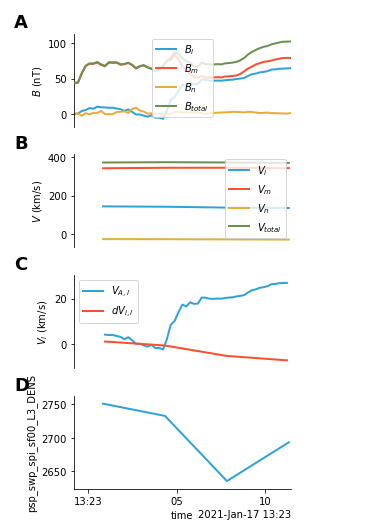

01-Jul-24 14:18:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



None

01-Jul-24 14:18:42: psp_fld_l2_mag_RTN_4_Sa_per_Cyc_temp is currently not in pytplot.
2024-07-01 14:18:42.515 | INFO     | space_analysis.ds.tplot.formulary:ts_Alfven_speed:22 - Time of B and density are not the same, interpolating density to B


:Layout
   .Overlay.B  :Overlay
      .NdOverlay.B :NdOverlay   [v_dim]
         :Curve   [time]   ($B$)
   .Overlay.V  :Overlay
      .NdOverlay.V :NdOverlay   [v_dim]
         :Curve   [time]   ($V$)
   .Overlay.I  :Overlay
      .Curve.V_left_curly_bracket_A_comma_l_right_curly_bracket  :Curve   [time]   ($V_{A,l}$)
      .Curve.DV_left_curly_bracket_i_comma_l_right_curly_bracket :Curve   [time]   ($dV_{i,l}$)
   .Overlay.II :Overlay
      .Curve.I :Curve   [time]   (psp_swp_spi_sf00_L3_DENS)
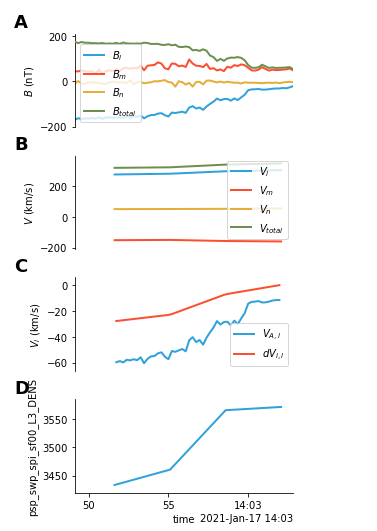

In [17]:
# | layout-ncol: 2
# | column: page
pytplot.tplot_options("ysize", 10)

title = "Ion anisotropy: {:.2f} Theory anisotropy: {:.2f}"

for event in events.head(n=n).rows(named=True):
    fig, axs = plot_event(event)
    axs[0].set_title(title.format(event["Λ_ion"], event["Λ_t"]))
    fig.show()
    display(plot_candidate_tplot(event))